# Custom observer tutorial

The goal of this tutorial is to setup a custom observer that will be able to monitor certain events of the simulation.


In [2]:
%matplotlib inline

from pydistsim import NetworkGenerator, Simulation
from pydistsim.logging import set_log_level, LogLevels, enable_logger

set_log_level(LogLevels.INFO)
enable_logger()

### Algorithm

To demonstrate this, we will re-use the `Echo` algorithm from the "Hello World" example. The algorithm is a simple
flooding algorithm that sends a message to all neighbors and waits for the response from all of them.
Once every neighbor responds, the algorithms terminates.

The observer will be able to monitor the following events:

- 'echo_response_received': This event is triggered when a response is received from a neighbor.
- 'echo_terminated': This event is triggered when the algorithm terminates.

Implementation of `Echo` algorithm is given below. Notice the `self.notify_observers()` method that is called whenever
an event occurs.


In [3]:
from enum import StrEnum
from pydistsim.algorithm.node_algorithm import NodeAlgorithm, StatusValues
from pydistsim.algorithm.node_wrapper import NodeAccess
from pydistsim.message import Message
from pydistsim.restrictions.communication import BidirectionalLinks
from pydistsim.restrictions.reliability import TotalReliability
from pydistsim.restrictions.topological import Connectivity, UniqueInitiator


class EchoEvents(StrEnum):
    echo_response_received = "echo_response_received"
    echo_terminated = "echo_terminated"


class Echo(NodeAlgorithm):
    default_params = {
        "echo_message": "Hello world!",
    }

    class Status(StatusValues):
        INITIATOR = "INITIATOR"
        AWAITING_ECHO = "AWAITING_ECHO"
        AWAITING_ECHO_RESPONSE = "AWAITING_ECHO_RESPONSE"
        DONE = "DONE"

    S_init = (Status.INITIATOR, Status.AWAITING_ECHO)
    S_term = (Status.DONE,)

    # Here we define under which restrictions the algorithm is designed to work
    algorithm_restrictions = (
        BidirectionalLinks,  # The algorithm requires bidirectional links, so that the response can be sent back
        TotalReliability,  # The algorithm requires that all messages are delivered without loss
        Connectivity,  # The algorithm requires that the network is connected
        UniqueInitiator,  # The algorithm requires that only one node is the initiator
    )

    def initializer(self):
        # Set all nodes to AWAITING_ECHO
        for node in self.network.nodes():
            node.status = self.Status.AWAITING_ECHO

        # Choose the initiator
        ini_node = self.network.nodes_sorted()[0]

        # Send the initial message to the initiator
        ini_node.push_to_inbox(Message(meta_header=NodeAlgorithm.INI, destination=ini_node))

        # Set the initiator status to INITIATOR and store the initial information
        ini_node.status = self.Status.INITIATOR
        ini_node.memory["message"] = self.echo_message

    @Status.INITIATOR
    def spontaneously(self, node: NodeAccess, message: Message):
        self.send(
            node,
            data=node.memory["message"],
            destination=list(node.neighbors()),  # send to all neighbors
            header="Echo",
        )
        node.memory["responseCount"] = 0
        node.status = self.Status.AWAITING_ECHO_RESPONSE

    @Status.AWAITING_ECHO_RESPONSE
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == "Echo response":
            self.notify_observers(EchoEvents.echo_response_received, node=node, message=message)

            # Count the number of responses received, only if the response is the same as the original message
            node.memory["responseCount"] += 1 if message.data == node.memory["message"] else 0

            # If all responses have been received, set the node status to DONE
            if node.memory["responseCount"] == len(list(node.neighbors())):
                self.notify_observers(EchoEvents.echo_terminated, node=node)
                node.status = self.Status.DONE

    @Status.AWAITING_ECHO
    def receiving(self, node: NodeAccess, message: Message):
        if message.header == "Echo":
            node.memory["message"] = message.data

            self.send(
                node,
                data=message.data,
                destination=message.source,
                header="Echo response",
            )
        node.status = self.Status.DONE

    @Status.DONE
    def default(self, *args, **kwargs):
        "Do nothing, for all inputs."
        pass

### Observer

The observer will be implemented as a class that inherits from both `AlgorithmObserver` and `SimulationObserver` classes.


In [4]:
from pydistsim.observers import AlgorithmObserver, SimulationObserver
from pydistsim.network import Node


class EchoObserver(AlgorithmObserver, SimulationObserver):
    events = [
        EchoEvents.echo_response_received,
        EchoEvents.echo_terminated,
    ]

    def __init__(self):
        self.list_of_events = []

    def on_echo_response_received(self, node: NodeAccess, message: Message):
        actual_node: Node = node.unbox()
        actual_source: Node = message.source.unbox()
        print(f"Node {actual_node} received echo response from {actual_source}.")
        self.list_of_events.append("received")

    def on_echo_terminated(self, node: NodeAccess):
        actual_node: Node = node.unbox()
        print(f"Node {actual_node} terminated.")
        self.list_of_events.append("terminated")

### Assigning algorithm and observer to simulation


In [5]:
MESSAGE = "Hello distributed and observable world"

net = NetworkGenerator.generate_star_network(16)
observer = EchoObserver()
sim = Simulation(net)

sim.algorithms = ((Echo, {"echo_message": MESSAGE}),)
sim.add_observers(observer)

2024-10-22 23:39:48.901 | INFO     | pydistsim.simulation:__init__:59 - Simulation 0x7f58b45e3190 created successfully.


/mnt/d/Proyectos/pymote/docs/notebooks/../../pydistsim/network/network.py:560: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


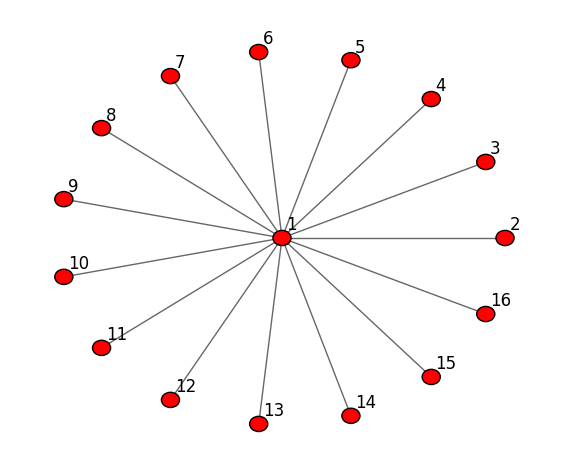

In [6]:
net.show()

### Running


Finally, run simulation:


In [7]:
sim.run()

Node <Node id=1> received echo response from <Node id=2>.
Node <Node id=1> received echo response from <Node id=3>.
Node <Node id=1> received echo response from <Node id=4>.
Node <Node id=1> received echo response from <Node id=5>.
Node <Node id=1> received echo response from <Node id=6>.
Node <Node id=1> received echo response from <Node id=7>.
Node <Node id=1> received echo response from <Node id=8>.
Node <Node id=1> received echo response from <Node id=9>.
Node <Node id=1> received echo response from <Node id=10>.
Node <Node id=1> received echo response from <Node id=11>.
Node <Node id=1> received echo response from <Node id=12>.
Node <Node id=1> received echo response from <Node id=13>.
Node <Node id=1> received echo response from <Node id=14>.
Node <Node id=1> received echo response from <Node id=15>.
Node <Node id=1> received echo response from <Node id=16>.
Node <Node id=1> terminated.
2024-10-22 23:39:52.911 | INFO     | pydistsim.simulation:_run_algorithm:148 - [Echo] Algorith

As we can see, the observer has executed the 'print' message me defied in the different trigger methods.

Now, we check if the observer has kept track of the events.


In [8]:
observer.list_of_events

['received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'received',
 'terminated']